In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# New Section

# **START**

In [ ]:
train_dir = '/content/fer2013/train'
test_dir = '/content/fer2013/test'

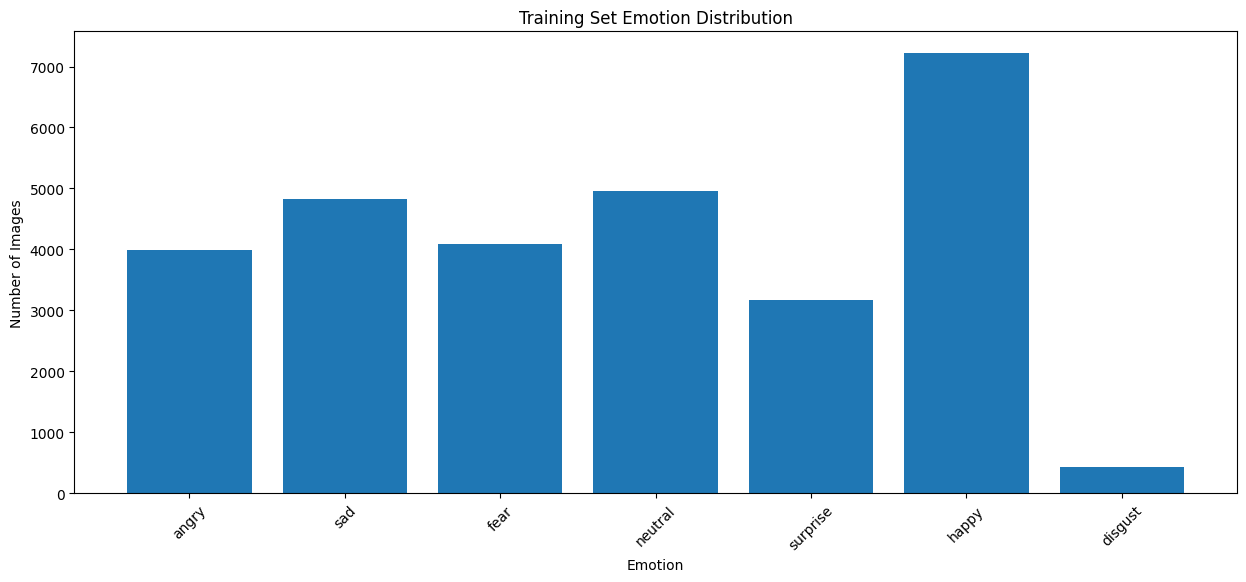

In [ ]:
train_class_names = os.listdir(train_dir)
train_class_counts = []

for class_name in train_class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        train_class_counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(15, 6))
plt.bar(train_class_names, train_class_counts)
plt.title("Training Set Emotion Distribution")
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

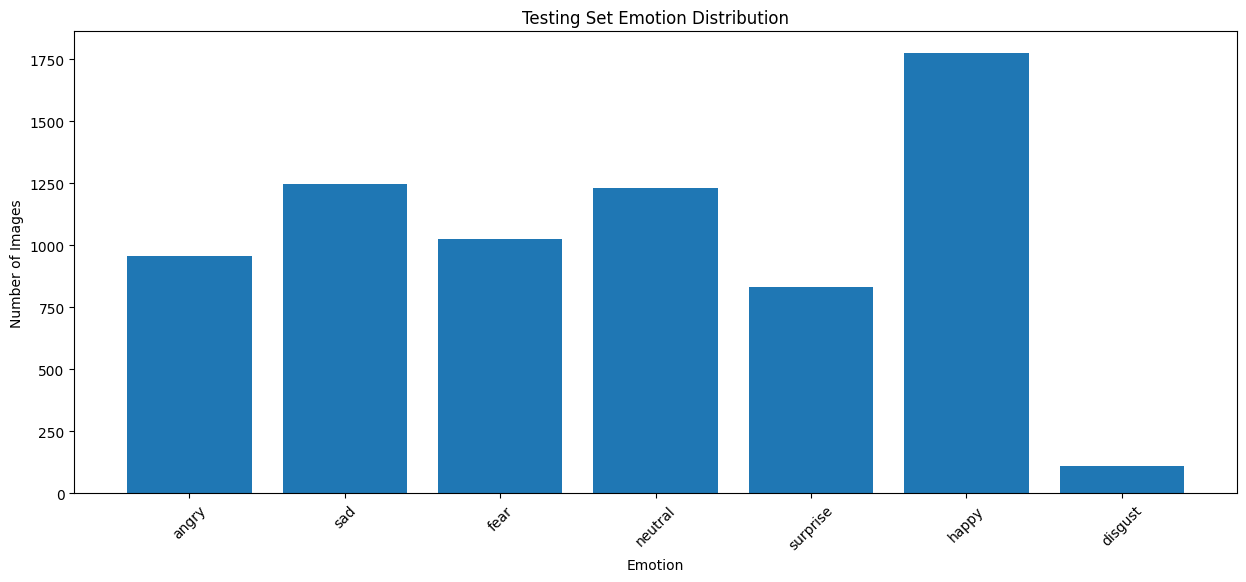

In [ ]:
test_class_names = os.listdir(test_dir)
test_class_counts = []

for class_name in test_class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        test_class_counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(15, 6))
plt.bar(test_class_names, test_class_counts)
plt.title("Testing Set Emotion Distribution")
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [ ]:
emotions = os.listdir(train_dir)

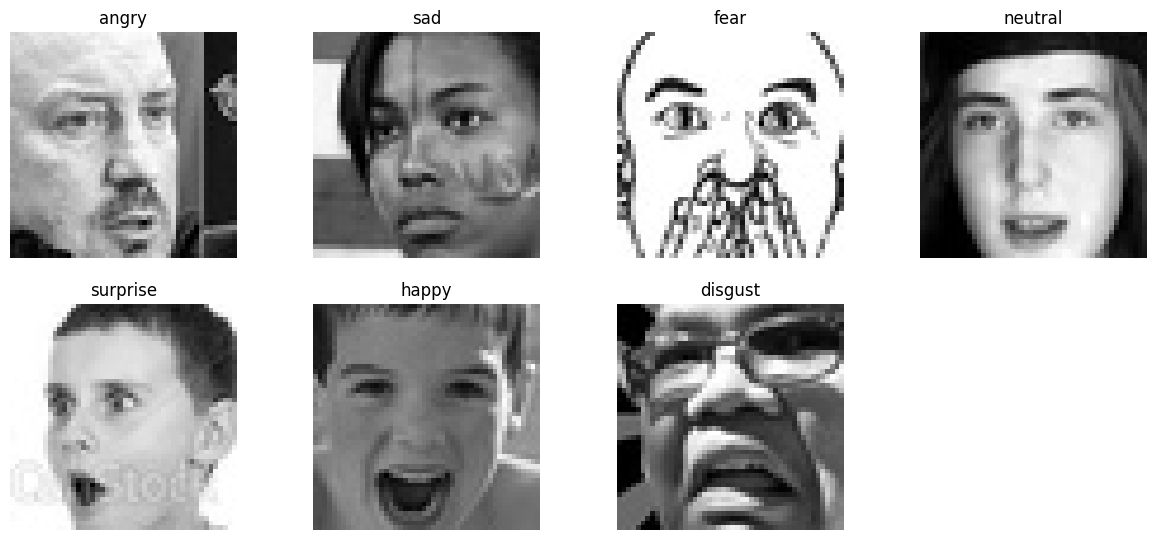

In [ ]:
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

In [ ]:
img_shape = 224
batch_size = 64

In [ ]:
train_data  = train_datagen.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Calculating class weights**

In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

NameError: name 'train_generator' is not defined

In [ ]:
input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Freezing all layers except last 50

base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

In [ ]:
model = Sequential([
    base_model,
    Dropout(.25),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(.5),
    Dense(7,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = val_data.n // val_data.batch_size

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 418s 855ms/step - accuracy: 0.4100 - loss: 1.8067 - val_accuracy: 0.5040 - val_loss: 1.4084 - learning_rate: 0.0010
Epoch 2/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:44 234ms/step - accuracy: 0.5000 - loss: 1.3806

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5000 - loss: 1.3806 - val_accuracy: 0.5063 - val_loss: 1.3903 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 366s 817ms/step - accuracy: 0.5302 - loss: 1.2839 - val_accuracy: 0.5773 - val_loss: 1.1434 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5938 - loss: 1.0641 - val_accuracy: 0.5805 - val_loss: 1.1368 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 365s 814ms/step - accuracy: 0.5870 - loss: 1.1379 - val_accuracy: 0.6182 - val_loss: 1.0362 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6562 - loss: 1.0038 - val_accuracy: 0.6183 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 382s 850ms/step - accuracy: 0.6058 - loss: 1.0733 - val_accuracy: 0.6247 - val_loss: 1.0212 - learning_rate: 0.0010
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5000 - loss: 

In [ ]:
model.save('emotion_recognition_model.h5')

In [ ]:
model.save('emotion_recognition_model.keras')

In [ ]:
# Save weights only
model.save_weights('emotion_recognition_model.weights.h5')

In [ ]:
Score = model.evaluate(val_data)

print("    Test Loss: {:.5f}".format(Score[0]))
print("Test Accuracy: {:.2f}%".format(Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.6437 - loss: 0.9832
    Test Loss: 0.89198
Test Accuracy: 68.32%


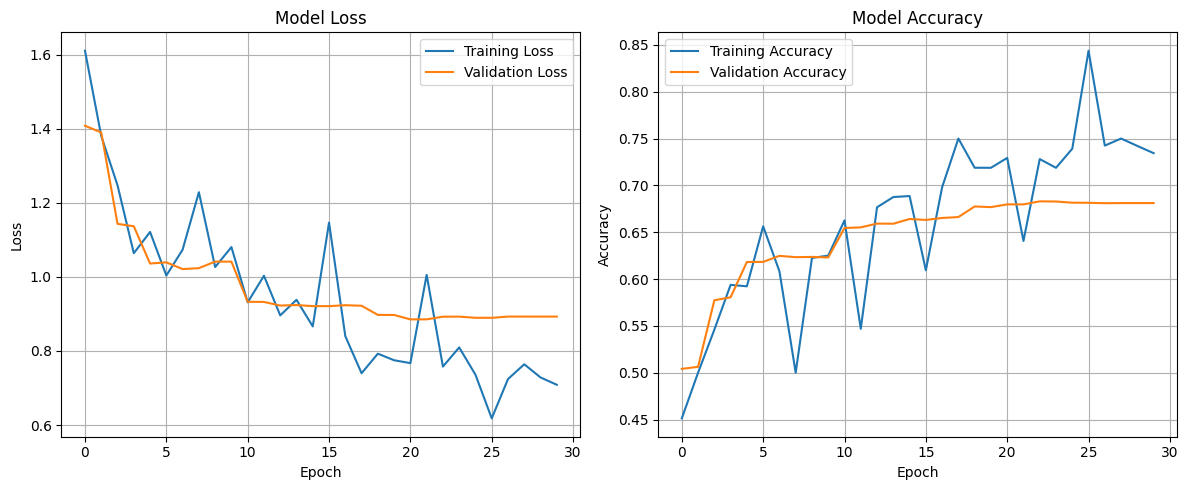

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
y_true = val_data.classes

val_data.reset()
y_pred_probabilities = model.predict(val_data)
y_pred = np.argmax(y_pred_probabilities, axis=1)

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print("Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=emotion_labels)
print(report)

113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step
Classification Report:

              precision    recall  f1-score   support

       Angry       0.58      0.64      0.61       958
     Disgust       0.71      0.43      0.54       111
        Fear       0.55      0.41      0.47      1024
       Happy       0.87      0.88      0.88      1774
         Sad       0.63      0.71      0.67      1233
    Surprise       0.58      0.58      0.58      1247
     Neutral       0.78      0.79      0.78       831

    accuracy                           0.68      7178
   macro avg       0.67      0.64      0.65      7178
weighted avg       0.68      0.68      0.68      7178



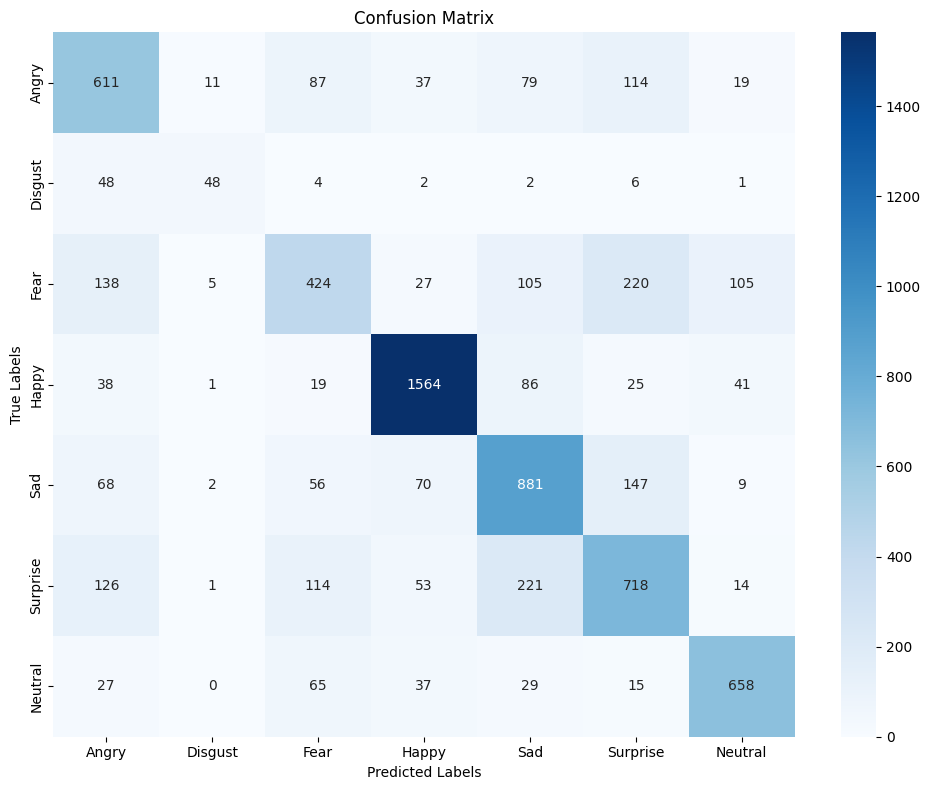

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
ResNet50V2_Predictions = model.predict(test_data)

ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)